In [1]:
from phi.tf.flow import *

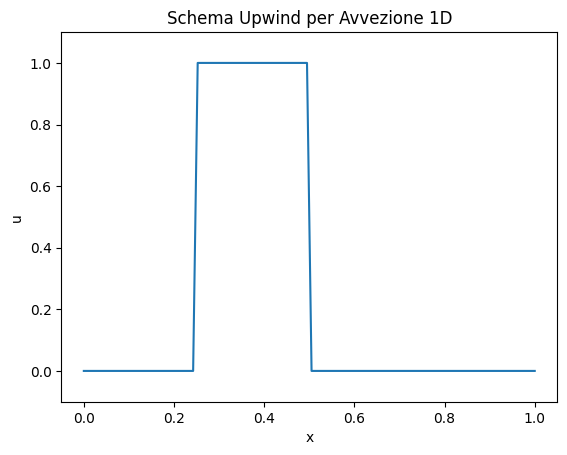

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def upwind_advection_1d(u0, a, dx, dt, t_max):
    nx = len(u0)
    nt = int(t_max / dt)
    u = u0.copy()
    lambda_ = a * dt / dx
    history = [u.copy()]
    
    for _ in range(nt):
        u_new = u.copy()
        
        if a > 0:
            for i in range(1, nx):
                u_new[i] = u[i] - lambda_ * (u[i] - u[i-1])
        else:
            for i in range(nx-1):
                u_new[i] = u[i] - lambda_ * (u[i+1] - u[i])
        
        u = u_new.copy()
        history.append(u.copy())
    
    return history

# Parametri
nx = 100
dx = 1.0 / nx
dt = 0.4 * dx
t_max = 2.0
a = 1.0

# Condizione iniziale
u0 = np.zeros(nx)
u0[int(nx/4):int(nx/2)] = 1

# Simulazione
history = upwind_advection_1d(u0, a, dx, dt, t_max)

# Animazione
fig, ax = plt.subplots()
x = np.linspace(0, 1, nx)
line, = ax.plot(x, history[0])
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.set_title("Schema Upwind per Avvezione 1D")

def update(frame):
    line.set_ydata(history[frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(history), interval=50)

plt.show()
plt.pause(0.01)  # Assicura che l'animazione venga visualizzata


In [25]:
# Estrazione della soluzione a tempo intermedio
t_intermediate = int(len(history) / 2)
solution_intermediate = history[t_intermediate]
print("Soluzione a tempo intermedio:", solution_intermediate)


Soluzione a tempo intermedio: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.44994837e-56 5.78441344e-54 4.83027272e-52
 2.67844114e-50 1.10952473e-48 3.66234071e-47 1.00339020e-45
 2.34692091e-44 4.78402042e-43 8.63349430e-42 1.39658643e-40
 2.04547899e-39 2.73505381e-38 3.36202028e-37 3.82181171e-36
 4.03819843e-35 3.98367008e-34 3.68340605e-33 3.20320763e-32
 2.62800199e-31 2.03971474e-30 1.50140114e-29 1.05047767e-28
 7.00053457e-28 4.45189489e-27 2.70629926e-26 1.57511633e-25
 8.79005349e-25 4.70979341e-24 2.42600221e-23 1.20273368e-22
 5.74530056e-22 2.64707620e-21 1.17746531e-20 5.06115982e-20
 2.10397886e-19 8.46584034e-19 3.29962612e-18 1.2466257

In [27]:
N = 100
DX = 2/N
STEPS = 32
DT = 1/STEPS
NU = 0.01/(N*np.pi)

# allocate velocity grid
velocity = CenteredGrid(0, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))

# and a grid with the reference solution 
REFERENCE_DATA = math.tensor(solution_intermediate , math.spatial('x'))
SOLUTION_T16 = CenteredGrid( REFERENCE_DATA, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))

In [3]:
'''def loss_function(velocity):
    velocities = [velocity]
    for time_step in range(STEPS):
        v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, substeps=1)
        v2 = advect.semi_lagrangian(v1, v1, DT)
        velocities.append(v2)
    loss = field.l2_loss(velocities[16] - SOLUTION_T16)*2./N # MSE
    return loss, velocities

gradient_function = math.gradient(loss_function)

(loss,velocities), grad = gradient_function(velocity)

print('Loss: %f' % (loss))'''

"def loss_function(velocity):\n    velocities = [velocity]\n    for time_step in range(STEPS):\n        v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, substeps=1)\n        v2 = advect.semi_lagrangian(v1, v1, DT)\n        velocities.append(v2)\n    loss = field.l2_loss(velocities[16] - SOLUTION_T16)*2./N # MSE\n    return loss, velocities\n\ngradient_function = math.gradient(loss_function)\n\n(loss,velocities), grad = gradient_function(velocity)\n\nprint('Loss: %f' % (loss))"

In [28]:

def loss_function(velocity):
    velocities = [velocity]
    for time_step in range(STEPS):
        # Remove diffusion, keeping only advection
        v2 = advect.semi_lagrangian(velocities[-1], velocities[-1], DT)
        velocities.append(v2)

    # Compute MSE loss
    loss = field.l2_loss(velocities[16] - SOLUTION_T16) * 2. / N
    return loss, velocities

# Compute gradient
gradient_function = math.gradient(loss_function)

(loss, velocities), grad = gradient_function(velocity)

print('Loss: %f' % loss)


Loss: 0.000000


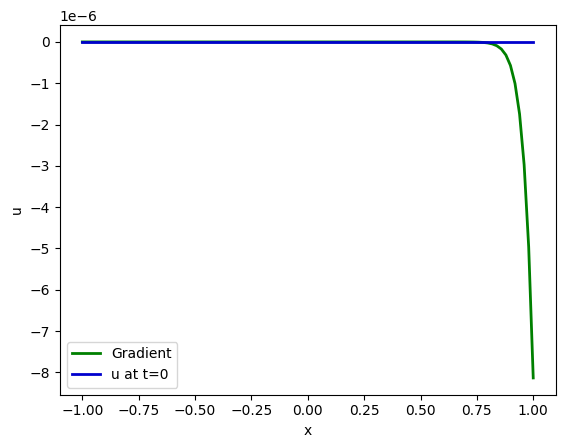

In [29]:
import pylab as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

# first gradient
fig.plot(pltx, grad[0].values.numpy('x')           , lw=2, color='green',      label="Gradient")  
fig.plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue', label="u at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend();

# some (optional) other fields to plot:
# fig.plot(pltx,  (velocities[16]).values.numpy('x')   , lw=2, color='cyan', label="u at t=0.5")  
# fig.plot(pltx,  (SOLUTION_T16).values.numpy('x')   , lw=2, color='red', label="solution at t=0.5")  
# fig.plot(pltx,  (velocities[16] - SOLUTION_T16).values.numpy('x')   , lw=2, color='blue', label="difference at t=0.5")  


In [30]:
LR = 5.

grads=[]
for optim_step in range(5):
    (loss,velocities), grad = gradient_function(velocity)
    print('Optimization step %d, loss: %f' % (optim_step,loss))
    grads.append( grad[0] )

    velocity = velocity - LR * grads[-1]


Optimization step 0, loss: 0.000000
Optimization step 1, loss: 0.000000
Optimization step 2, loss: 0.000000
Optimization step 3, loss: 0.000000
Optimization step 4, loss: 0.000000


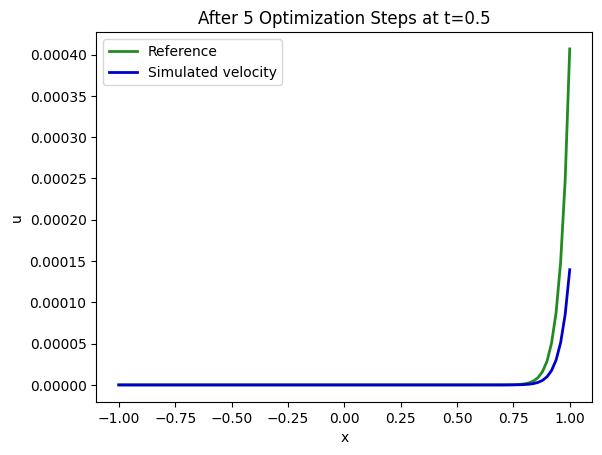

In [31]:
fig = plt.figure().gca()

# target constraint at t=0.5
fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw=2, color='forestgreen',  label="Reference") 

# optimized state of our simulation after 16 steps
fig.plot(pltx, velocities[16].values.numpy('x'), lw=2, color='mediumblue', label="Simulated velocity")

plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("After 5 Optimization Steps at t=0.5");

In [32]:
import time
start = time.time()

for optim_step in range(5,50):
    (loss,velocities), grad = gradient_function(velocity)
    velocity = velocity - LR * grad[0]
    if optim_step%5==0: 
      print('Optimization step %d, loss: %f' % (optim_step,loss))

end = time.time()
print("Runtime {:.2f}s".format(end-start))

Optimization step 5, loss: 0.000000
Optimization step 10, loss: 0.000000
Optimization step 15, loss: 0.000000
Optimization step 20, loss: 0.000000
Optimization step 25, loss: 0.000000
Optimization step 30, loss: 0.000000
Optimization step 35, loss: 0.000000
Optimization step 40, loss: 0.000000
Optimization step 45, loss: 0.000000
Runtime 46.37s


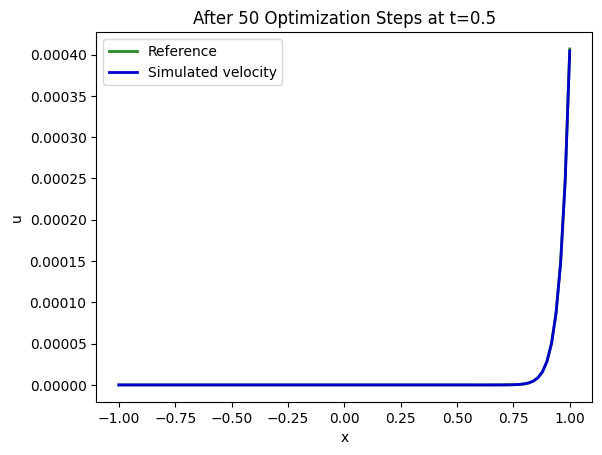

In [42]:
fig = plt.figure().gca()
fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw=2, color='forestgreen',  label="Reference") 
fig.plot(pltx, velocities[16].values.numpy('x'), lw=2, color='mediumblue', label="Simulated velocity")
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("After 50 Optimization Steps at t=0.5");

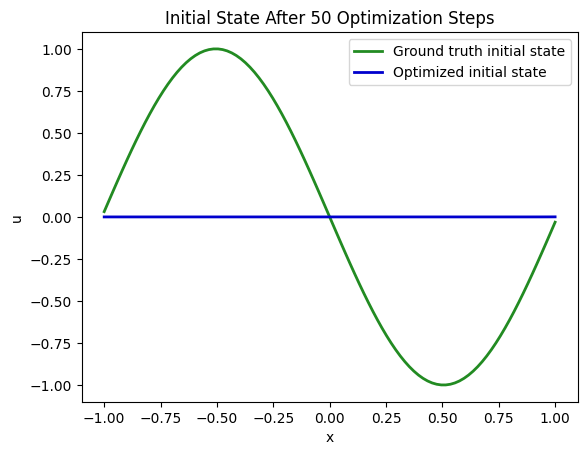

In [34]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

# ground truth state at time=0 , move down
INITIAL_GT = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpy array
fig.plot(pltx, INITIAL_GT.flatten()      , lw=2, color='forestgreen', label="Ground truth initial state")  # ground truth initial state of sim
fig.plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue',  label="Optimized initial state") # manual
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("Initial State After 50 Optimization Steps");


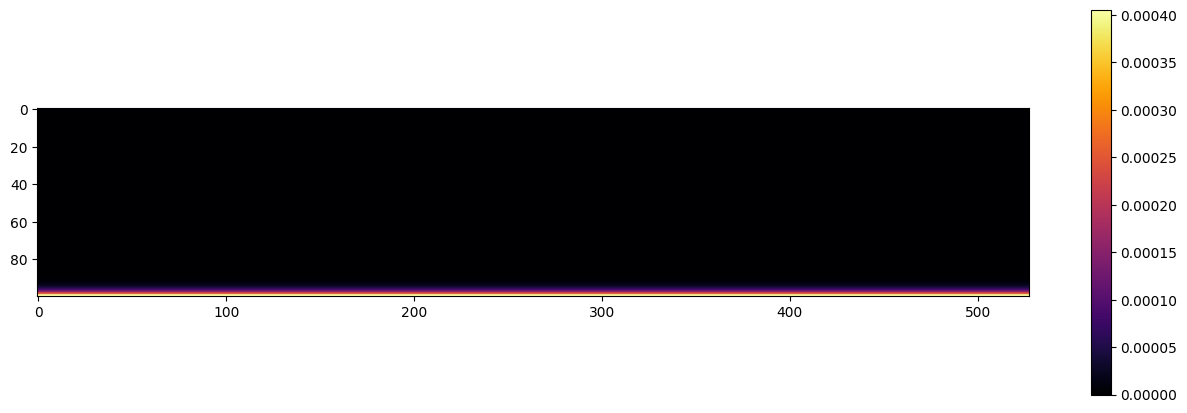

In [35]:
import pylab

def show_state(a):
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) 
        
# get numpy versions of all states 
vels = [ x.values.numpy('x,vector') for x in velocities] 
# concatenate along vector/features dimension
vels = np.concatenate(vels, axis=-1) 

# save for comparison with other methods
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-diffphys-solution.npz", np.reshape(vels,[N,STEPS+1])) # remove batch & channel dimension

show_state(vels)